**Import Major Libraries**

In [18]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns


# Data Loading and Preparation

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merged_data.csv')

# Display the first few rows of the dataset to understand its structure
df.head()

# Display data summary for initial exploration
#print(df.info())
#print(df.describe())


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Outcome type,Crime type,Last outcome category,Context
0,69753024d1a1be0b32a28f6ed290a81f38f6bd939b4c8f...,2021-07,City of London Police,City of London Police,NaN,NaN,No location,NaN,NaN,Investigation complete; no suspect identified,NaN,NaN,NaN
1,f98bdd6457789507072a0e0f86ad8af7e43ee977690ebf...,2021-07,City of London Police,City of London Police,NaN,NaN,No location,NaN,NaN,Investigation complete; no suspect identified,NaN,NaN,NaN
2,8b4cf7dd1da31d8a9ad164be06f8e682a206dc8669e946...,2021-07,City of London Police,City of London Police,-0.085669,51.515100,On or near AUSTIN FRIARS,E01032739,City of London 001F,Investigation complete; no suspect identified,NaN,NaN,NaN
3,f13ab485a366569a308101c76257d577d1e993fc5a6eff...,2021-07,City of London Police,City of London Police,-0.077601,51.518799,On or near STEWARD STREET,E01004307,Tower Hamlets 015B,Investigation complete; no suspect identified,NaN,NaN,NaN
4,ea4d2356eb69b8be974c04a328d90adb6fa1954173200e...,2021-07,City of London Police,City of London Police,-0.073515,51.510414,On or near Parking Area,E01000005,City of London 001E,Investigation complete; no suspect identified,NaN,NaN,NaN


# Data Preprocessing

**Data Cleaning**

In [21]:

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values before cleaning:\n", missing_values)

# Drop rows with missing Longitude and Latitude, as they are essential for clustering
df_clean = df.dropna(subset=['Longitude', 'Latitude']).copy()  # Make a copy to avoid SettingWithCopyWarning

# Fill missing 'Crime type', 'Outcome type', and 'Last outcome category' with 'Unknown'
df_clean['Crime type'] = df_clean['Crime type'].fillna('Unknown')
df_clean['Outcome type'] = df_clean['Outcome type'].fillna('Unknown')
df_clean['Last outcome category'] = df_clean['Last outcome category'].fillna('Unknown')

# Drop unnecessary columns
df_clean = df_clean.drop(columns=['Context'])

# Drop any remaining rows with missing values
df_clean.dropna(inplace=True)

# Check the resulting DataFrame to ensure there are no more missing values
print("Missing values after cleaning:\n", df_clean.isnull().sum())

# Display the DataFrame columns
print("DataFrame columns:\n", df_clean.columns)


Missing values before cleaning:
 Crime ID                  2060
Month                        0
Reported by                  0
Falls within                 0
Longitude                 3277
Latitude                  3277
Location                     0
LSOA code                 3277
LSOA name                 3277
Outcome type             26983
Crime type               18839
Last outcome category    20899
Context                  45822
dtype: int64
Missing values after cleaning:
 Crime ID                 0
Month                    0
Reported by              0
Falls within             0
Longitude                0
Latitude                 0
Location                 0
LSOA code                0
LSOA name                0
Outcome type             0
Crime type               0
Last outcome category    0
dtype: int64
DataFrame columns:
 Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Outcome type',
       'Crime typ

**Data Splitting and Standardization**

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Selecting only numeric features for X (excluding target and non-numeric columns like 'Crime ID')
X = df_clean.select_dtypes(include=[float, int]).copy()  # Select only numeric columns
y = df_clean['Crime type']  # Target variable (categorical)

# Splitting the data into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardizing the numeric features
scaler = StandardScaler()

# Fit only on training data and transform training and testing data separately
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Checking the size of the training and testing sets
print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Testing set size: {X_test.shape}, {y_test.shape}")

# Print a sample to see the transformed data
print("Sample of the scaled training data:\n", X_train_scaled[:5])


Training set size: (28445, 2), (28445,)
Testing set size: (12191, 2), (12191,)
Sample of the scaled training data:
 [[-1.86440479 -0.22208456]
 [-0.35035716  1.44711467]
 [-1.65715251  0.60650894]
 [-1.75120946  1.66358504]
 [ 0.27178438 -0.29641022]]


# Exploratory Data Analysis

**Frequency Distribution of Crime Types**

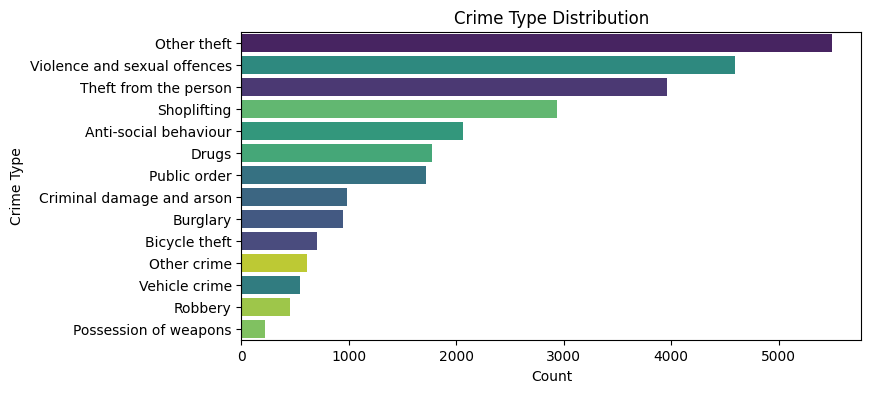

In [23]:
# Count of different crime types
plt.figure(figsize=(8, 4))
sns.countplot(y='Crime type', data=df, order=df['Crime type'].value_counts().index, hue='Crime type', palette="viridis", dodge=False)
plt.title('Crime Type Distribution')
plt.xlabel('Count')
plt.ylabel('Crime Type')

# Set the legend to False since it is not needed here
plt.legend([],[], frameon=False)

plt.show()


This bar chart shows the distribution of different crime types. **"Other theft"** is the most common crime type, with over 5,000 incidents, followed by **"Violence and sexual offences"** and **"Theft from the person"**, both of which also have high counts. Crimes such as **shoplifting**, **anti-social behavior**, and **drugs** also have significant representation.

Less frequent crimes include **burglary**, **bicycle theft**, **other crime**, and **vehicle crime**, with fewer than 1,000 incidents each. **Possession of weapons** has the lowest occurrence among the crime types listed, making it a relatively rare crime in comparison. This distribution highlights that theft-related offenses and violent crimes are the most prevalent in the dataset.

**Frequency Distribution of Outcome Types**

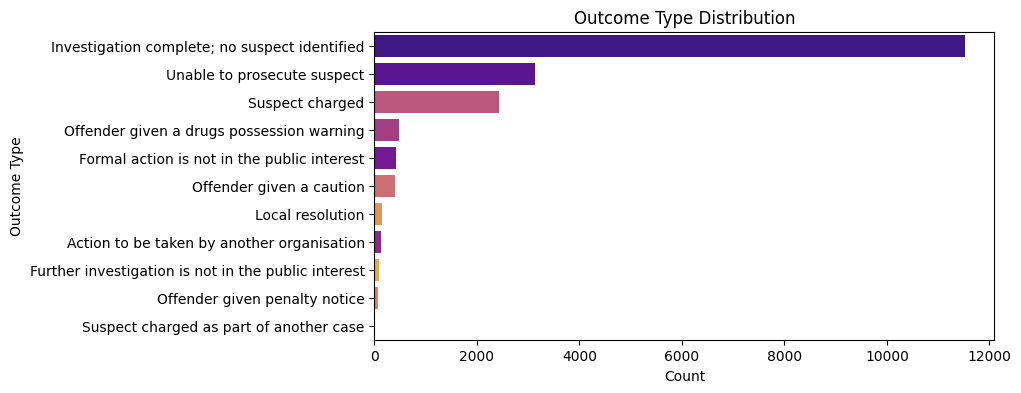

In [24]:
# Count of different outcome types
plt.figure(figsize=(8, 4))
sns.countplot(y='Outcome type', data=df, order=df['Outcome type'].value_counts().index, hue='Outcome type', palette="plasma", dodge=False)

# Disable the legend, as it's not necessary for this plot
plt.legend([],[], frameon=False)

# Add plot titles and labels
plt.title('Outcome Type Distribution')
plt.xlabel('Count')
plt.ylabel('Outcome Type')

# Show the plot
plt.show()


This bar chart illustrates the distribution of different outcomes for crimes. The most common outcome is **"Investigation complete; no suspect identified"**, with nearly 12,000 cases, indicating a large number of unsolved crimes. The second most frequent outcome is **"Unable to prosecute suspect"**, showing significant challenges in bringing suspects to trial. **"Suspect charged"** is the third most common outcome, indicating successful prosecutions in some cases.

Less frequent outcomes include **offenders being given warnings** (like drug possession warnings), **formal action not being in the public interest**, and **cautions**. Other outcomes, such as **local resolution** and **action taken by another organization**, have even lower counts. The chart highlights that a large portion of cases either remain unresolved or fail to lead to prosecution.

**Top 10 LSOA Crime Count Distribution**

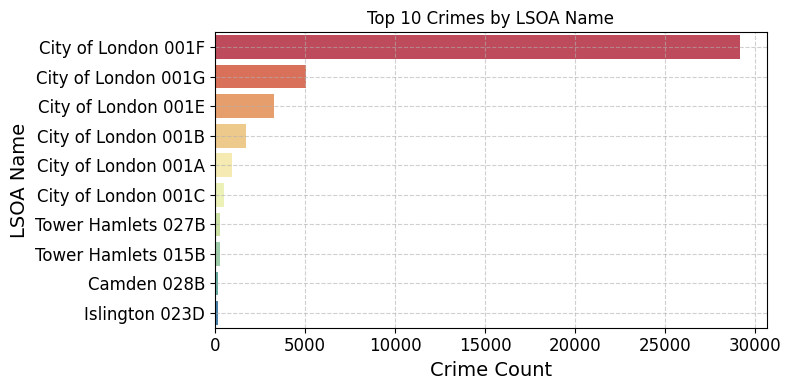

In [25]:
# Plot Crimes per LSOA name (top 10)
plt.figure(figsize=(8, 4))

# Use a colorful palette for the plot
sns.countplot(y='LSOA name', data=df, order=df['LSOA name'].value_counts().index[:10],
              palette='Spectral', dodge=False)

# Default title and axis labels
plt.title('Top 10 Crimes by LSOA Name')  # Default title formatting
plt.xlabel('Crime Count', fontsize=14)
plt.ylabel('LSOA Name', fontsize=14)

# Customize ticks for readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


This bar chart visualizes the top 10 crime counts by LSOA (Lower Super Output Area) names. The **City of London 001F** stands out significantly, with nearly 30,000 crimes, which is much higher compared to the other LSOA regions. Following this, **City of London 001G** and **City of London 001E** also have substantial crime counts, but at considerably lower numbers than 001F. Other areas like **Tower Hamlets 027B** and **Islington 023D** have much lower crime counts, indicating a much lower level of reported crimes in those areas. This chart highlights the concentration of crimes in specific areas, particularly in the City of London.

**Geospatial Distribution of Crimes by Latitude and Longitude**

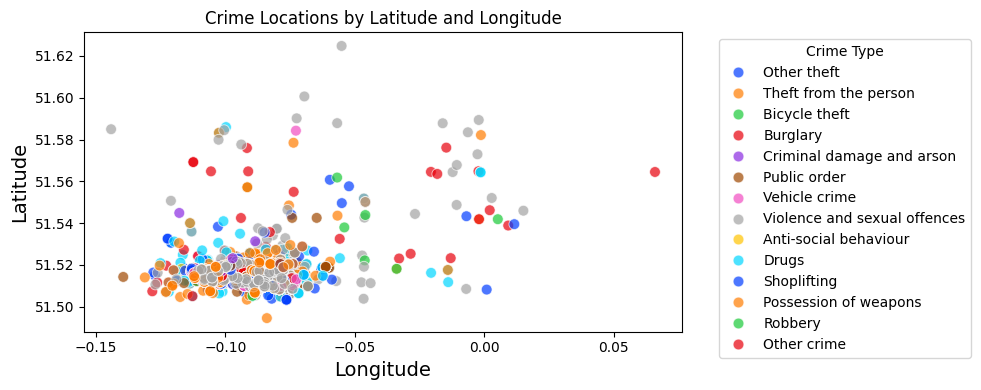

In [26]:
# Scatter plot of crime locations by longitude and latitude
plt.figure(figsize=(10, 4))

# Use a bright color palette for the scatter plot
sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='Crime type', alpha=0.7, s=60, palette='bright')

# Default title and axis labels
plt.title('Crime Locations by Latitude and Longitude')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Customize legend placement and colors
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=10, fontsize=10)

# Ensure all plot elements fit within the figure area
plt.tight_layout()

# Show the plot
plt.show()


This scatter plot illustrates the locations of different crime types based on latitude and longitude. The majority of crimes are concentrated in a specific region around latitude 51.52 and longitude -0.10. Crimes like **vehicle crime**, **burglary**, **violent and sexual offenses**, **anti-social behavior**, and **criminal damage and arson** are frequent in this area, as indicated by the colors in the legend. However, crimes like **robbery** and **other crimes** appear to be more dispersed in other areas. Each type of crime is represented by a different color, making it easier to identify the geographical spread of specific crimes within the dataset.

# Model Training

**DBSCAN Clustering**

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Applying DBSCAN on the training data with the best parameters
best_eps = 0.010
best_min_samples = 5
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)

# Fit the DBSCAN model on the training data
clusters_dbscan_train = dbscan.fit_predict(X_train_scaled)

# Adding the cluster labels to the training dataset (assign the labels back to the original dataframe)
df_clean_train = pd.DataFrame(X_train, columns=df_clean.columns.drop('Crime type'))
df_clean_train['Cluster_DBSCAN'] = clusters_dbscan_train

# Predict clusters for the test data
clusters_dbscan_test = dbscan.fit_predict(X_test_scaled)

# Adding the cluster labels to the test dataset
df_clean_test = pd.DataFrame(X_test, columns=df_clean.columns.drop('Crime type'))
df_clean_test['Cluster_DBSCAN'] = clusters_dbscan_test

# Display the first few rows of the clustered training set
print(df_clean_train.head())


       Crime ID  Month  Reported by  Falls within  Longitude   Latitude  \
7410        NaN    NaN          NaN           NaN  -0.108231  51.513928   
19871       NaN    NaN          NaN           NaN  -0.092488  51.520598   
23580       NaN    NaN          NaN           NaN  -0.106076  51.517239   
15450       NaN    NaN          NaN           NaN  -0.107054  51.521463   
13652       NaN    NaN          NaN           NaN  -0.086019  51.513631   

       Location  LSOA code  LSOA name  Outcome type  Last outcome category  \
7410        NaN        NaN        NaN           NaN                    NaN   
19871       NaN        NaN        NaN           NaN                    NaN   
23580       NaN        NaN        NaN           NaN                    NaN   
15450       NaN        NaN        NaN           NaN                    NaN   
13652       NaN        NaN        NaN           NaN                    NaN   

       Cluster_DBSCAN  
7410                0  
19871               1  
23580   

# Model Testing and Evaluation

In [28]:
# Predict clusters on the test set
clusters_dbscan_test = dbscan.fit_predict(X_test_scaled)

# Adding the cluster labels to the test dataset (create a new DataFrame for test set)
df_clean_test = pd.DataFrame(X_test, columns=df_clean.columns.drop('Crime type'))  # Create a DataFrame from X_test
df_clean_test['Cluster_DBSCAN'] = clusters_dbscan_test

In [29]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score on the training set
silhouette_train = silhouette_score(X_train_scaled, clusters_dbscan_train)
print(f"Silhouette Score for DBSCAN on Training Set: {silhouette_train:.4f}")

# Calculate Silhouette Score on the test set
silhouette_test = silhouette_score(X_test_scaled, clusters_dbscan_test)
print(f"Silhouette Score for DBSCAN on Test Set: {silhouette_test:.4f}")

Silhouette Score for DBSCAN on Training Set: 0.9536
Silhouette Score for DBSCAN on Test Set: 0.9002


The similarity between the training and test scores suggests that the DBSCAN model is not overfitting, and it is performing consistently across both sets.
The slight drop in the test score is expected but not significant enough to indicate any major issues with model generalization.


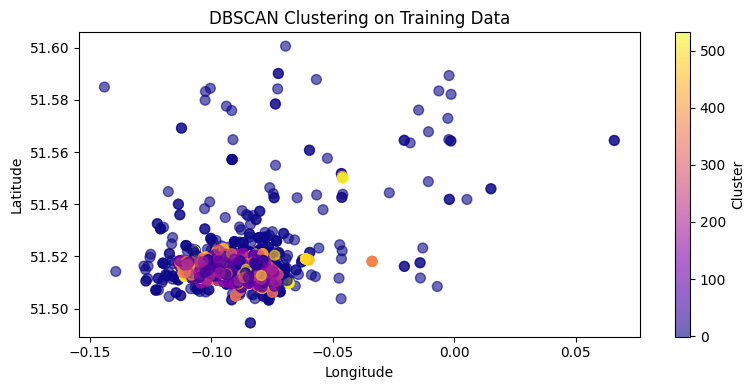

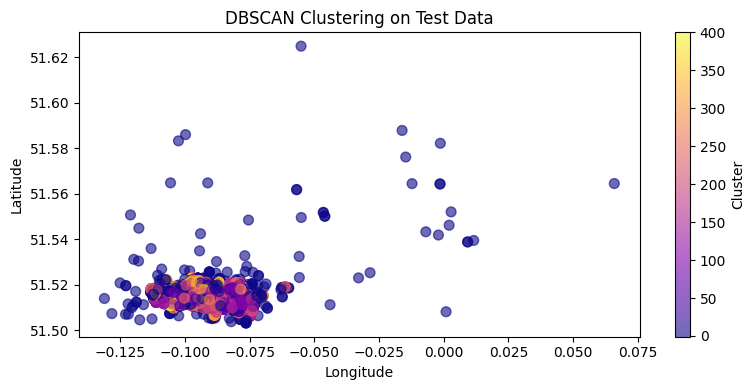

In [30]:
# Ensure that X_train and X_test are properly indexed
X_train_coords = X_train[['Longitude', 'Latitude']].values  # Convert to array for plotting
X_test_coords = X_test[['Longitude', 'Latitude']].values    # Convert to array for plotting

# Visualizing clusters on the training set
plt.figure(figsize=(8, 4))
plt.scatter(X_train_coords[:, 0], X_train_coords[:, 1], c=clusters_dbscan_train, cmap='plasma', s=50, alpha=0.6)
plt.title('DBSCAN Clustering on Training Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

# Visualizing clusters on the test set
plt.figure(figsize=(8, 4))
plt.scatter(X_test_coords[:, 0], X_test_coords[:, 1], c=clusters_dbscan_test, cmap='plasma', s=50, alpha=0.6)
plt.title('DBSCAN Clustering on Test Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


The two scatter plots show the results of **DBSCAN clustering** applied to crime locations on both the **training** and **test** datasets.

This DBSCAN clustering identifies consistent crime hotspots across both the training and test datasets, with a significant concentration of crime events around the coordinates **51.51, -0.10** in both sets. This indicates strong model performance in identifying meaningful clusters across unseen data.

In [31]:
import joblib

# Assuming 'dbscan' is your trained model
model_filename = '/content/drive/MyDrive/london_crime_detection_dbscan_model.pkl'  # model location in Google Drive
joblib.dump(dbscan, model_filename)

print(f"Model saved to {model_filename}")


Model saved to /content/drive/MyDrive/london_crime_detection_dbscan_model.pkl
